Load packages

In [309]:
import numpy as np
inf=float("inf")

import random
from tqdm import tqdm

import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import stablerank.srank as sr

Symmetrize matrices

In [290]:
class DataFile:
    def __init__(self, delay=1, subject=1, normalize=True, test=False):
        self.delay = delay
        self.subject = subject
        self.size = 200
        
        self.filename = "data/C200_delay"+str(delay)+"_asym_matrices/C200_delay"+str(delay)+"_Subject_"+str(subject)
        self.data_df = pd.read_csv(self.filename, header=None)
        self.data_mat = self.data_df.to_numpy()
            
        if test:
            self.size = 10
            self.data_mat = self.data_mat[:self.size,:self.size]   
            
        for i in range(self.size):
            for j in range(self.size):
                if self.data_mat[i,j] < 0:
                    self.data_mat[i,j] = 0
        
        if normalize:
            #matrix = self.data_mat.copy()
            #for i in range(self.size):
            #    matrix[i, i] = np.nan
            #max_val = np.nanmax(matrix)
            #min_val = np.nanmin(matrix)
            #self.data_mat = (matrix - min_val) / (max_val - min_val)
            #for i in range(self.size):
            #    self.data_mat[i, i] = 0
            max_val = np.max(self.data_mat)
            min_val = np.min(self.data_mat)
            self.data_mat = (self.data_mat - min_val) / (max_val - min_val)
            
        self.comp_mat = self.data_mat.copy()
            
    #def normalize(self, matrix):
    #    max_val = np.nanmax(matrix)
    #    min_val = np.nanmin(matrix)
    #    matrix_norm = (matrix - min_val) / (max_val - min_val)
    #    return matrix_norm
    
    def correlation_to_distance(self, cor_mat):
        dist_mat = 1 - cor_mat
        return dist_mat
        
    def symmetrize(self, symmetrization):        
        if symmetrization == "upper": 
            cor_mat = np.triu(self.comp_mat, k = 1) + np.transpose(np.triu(self.comp_mat, k = 1))
            
        elif symmetrization == "lower":
            cor_mat = np.tril(self.comp_mat, k = -1) + np.transpose(np.tril(self.comp_mat, k = -1))
            
        elif symmetrization == "maximum":
            upper_mat = np.triu(self.comp_mat, k = 1)
            lower_mat = np.tril(self.comp_mat, k = -1)
            cor_mat = np.maximum(upper_mat, np.transpose(lower_mat))  
            
        elif symmetrization == "minimum":
            upper_mat = np.triu(self.comp_mat, k = 1)
            lower_mat = np.tril(self.comp_mat, k = -1)
            cor_mat = np.minimum(upper_mat, np.transpose(lower_mat)) 
            
        elif symmetrization == "symmetric_part":
            cor_mat = 0.5*self.comp_mat + 0.5*np.transpose(self.comp_mat)
            
        elif symmetrization == "antisymmetric_part":
            cor_mat = 0.5*self.comp_mat - 0.5*np.transpose(self.comp_mat) + np.mean(self.comp_mat)
            
        elif symmetrization == "transpose_multiplication":
            cor_mat = (self.comp_mat@np.transpose(self.comp_mat)) / (self.size * np.mean(self.comp_mat))
            
            for i in range(self.size):
                cor_mat[i,i] = 0
                
        elif symmetrization == "two_nodes":
            P = np.zeros((2*self.size, self.size))
            Q = np.zeros((self.size, 2*self.size))
            A = self.comp_mat.copy()
            
            for i in range(self.size):
                A[i][i] = 1
                P[2*i][i] = 1
                Q[i][2*i+1] = 1
            
            temp_res = P@A@Q
            cor_mat = temp_res + np.transpose(temp_res) 
            
        else:
            print("invalid symmetrization method")
            return np.zeros((self.size, self.size))

        return cor_mat
    
    def symmetrize_pow(self, symmetrization, order):   
        cor_mat = self.symmetrize(symmetrization)
        
        for i in range(1, order):
            self.comp_mat = self.comp_mat@self.comp_mat / (self.size * np.mean(self.comp_mat))
            for i in range(self.size):
                self.comp_mat[i,i] = 0
                
            cor_mat += self.symmetrize(symmetrization)
            
        self.comp_mat = self.data_mat.copy()
        
        return cor_mat / order

In [233]:
test_mat = np.random.rand(3, 3)
np.sum(test_mat)

4.016775988844655

Basic investigations

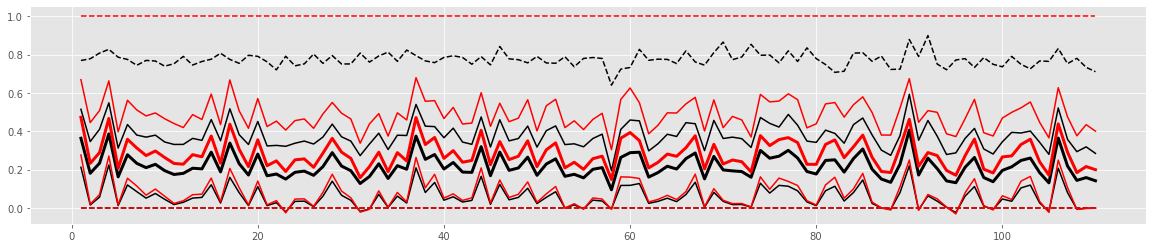

In [305]:
plt.rcParams["axes.grid"] = True
plt.figure(figsize=(20,4))

nr_of_subjects = 110
size = 200
mean_cors = np.zeros(nr_of_subjects)
std_cors = np.zeros(nr_of_subjects)
max_cors = np.zeros(nr_of_subjects)
min_cors = np.zeros(nr_of_subjects)
range_of_subjects = np.arange(1, nr_of_subjects+1)
#matrices = dict()

colors = ["k", "r"]
j = 0
for normalize in [False, True]:
    for subject in range_of_subjects:
        df = DataFile(subject=subject, normalize = normalize)
        cor_mat = df.data_mat
        #matrices[subject] = cor_mat
        for i in range(size):
            cor_mat[i,i] = np.nan
        mean_cors[subject-1] = np.nanmean(cor_mat)
        std_cors[subject-1] = np.nanstd(cor_mat)
        max_cors[subject-1] = np.nanmax(cor_mat)
        min_cors[subject-1] = np.nanmin(cor_mat)

    plt.plot(range_of_subjects, mean_cors, color = colors[j], linewidth = 3)
    plt.plot(range_of_subjects, mean_cors - std_cors, color = colors[j])
    plt.plot(range_of_subjects, mean_cors + std_cors, color = colors[j])
    plt.plot(range_of_subjects, min_cors, color = colors[j], linestyle = "--")
    plt.plot(range_of_subjects, max_cors, color = colors[j], linestyle = "--")
    j += 1

Apply methods to small test matrix

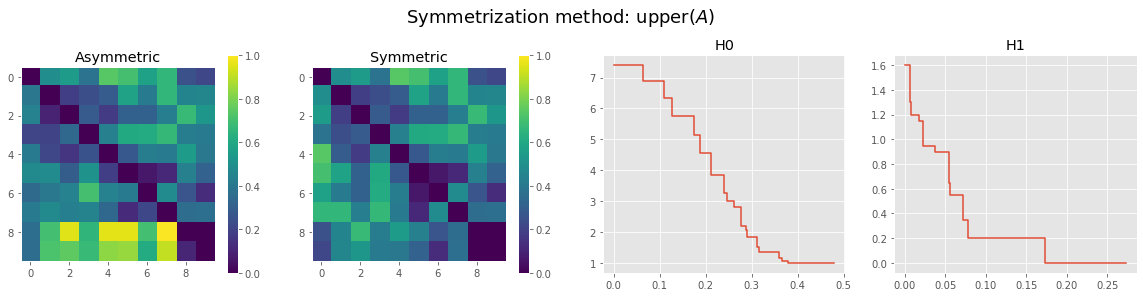

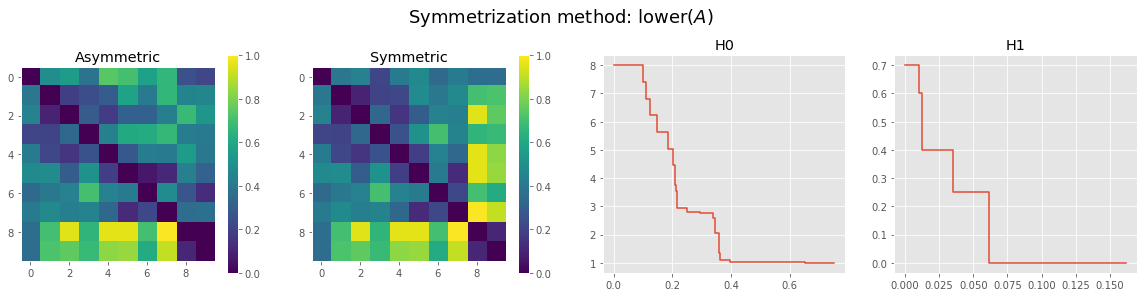

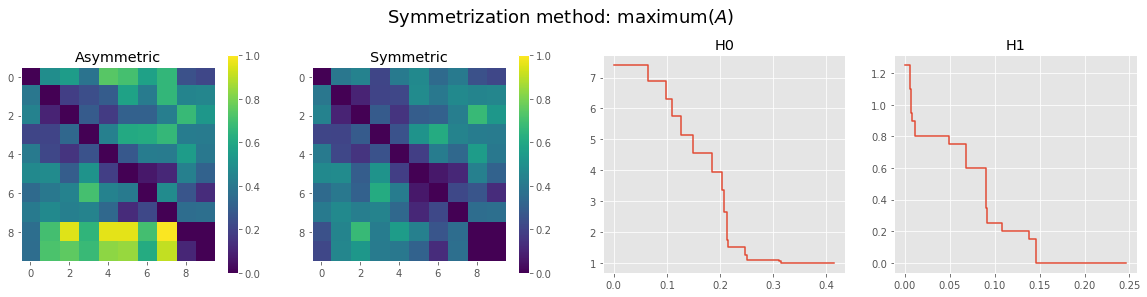

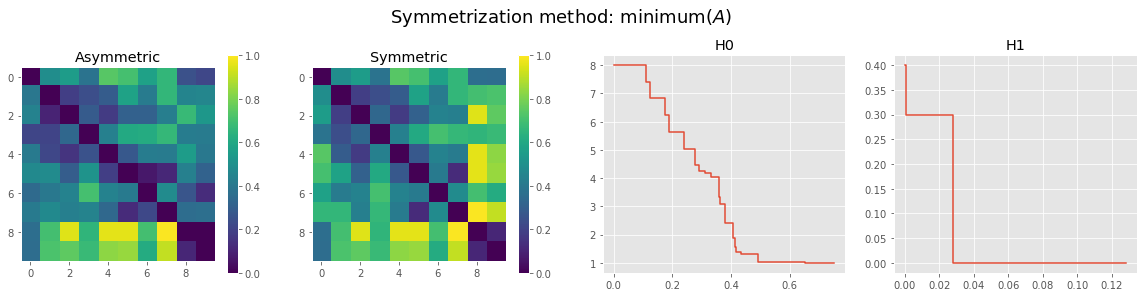

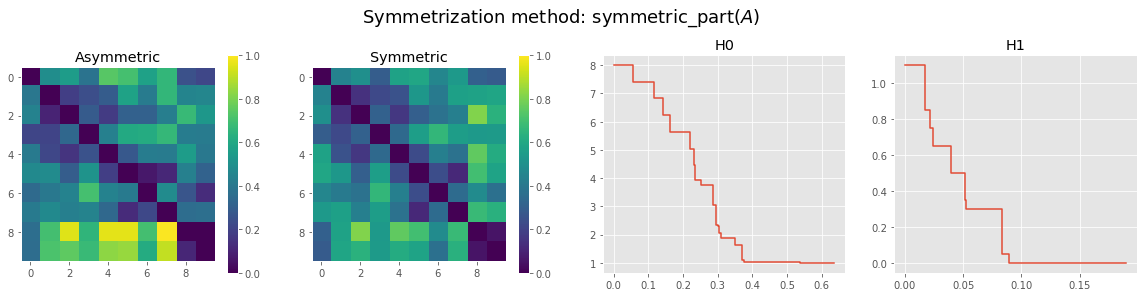

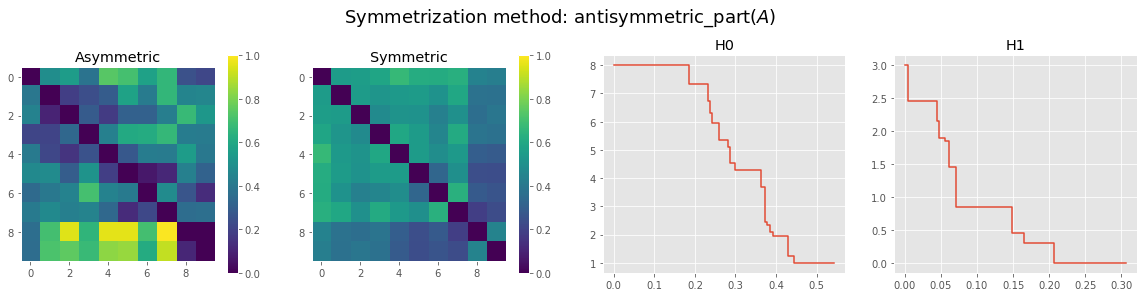

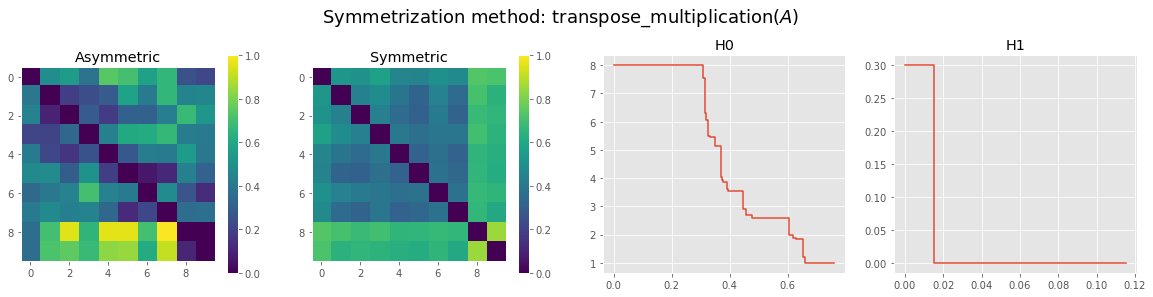

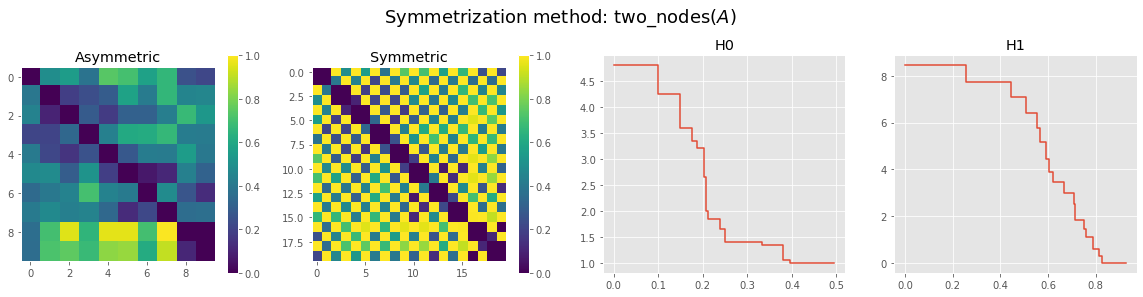

In [306]:
symmetrizations = ["upper", "lower", "maximum", "minimum", "symmetric_part", "antisymmetric_part", "transpose_multiplication", "two_nodes"]
normalize = True

number_instances = 20
sample_size = 8
probabilities = DataFile(test = True).size

s = sr.get_sample(number_instances, sample_size, probabilities)

df = DataFile(normalize = normalize, test = True)
max_val = 1

for symmetrization in symmetrizations:
    plt.rcParams["axes.grid"] = False
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,4))
    
    fig.suptitle("Symmetrization method: "+symmetrization+"($A$)", fontsize=18, y=1.05)
    
    d_mat = df.correlation_to_distance(df.symmetrize(symmetrization))
    original_mat = df.correlation_to_distance(df.data_mat)
    for i in range(len(original_mat)):
        original_mat[i, i] = 0
        
    d = sr.Distance(d_mat)
    #h0sr = d.get_h0sr(sample=s, clustering_method="single")
    bc = d.get_bc(maxdim=1, sample = s)
    h0sr = sr.bc_to_sr(bc, degree="H0")
    h1sr = sr.bc_to_sr(bc, degree="H1")
    
    ax1.set_title("Asymmetric")
    img = ax1.imshow(original_mat)
    plt.colorbar(img, ax = ax1)
    img.set_clim(0, max_val)
    #ax1.grid(None)
    
    ax2.set_title("Symmetric")
    img = ax2.imshow(d.square_form())
    plt.colorbar(img, ax = ax2)
    img.set_clim(0, max_val)
    #ax2.grid(None)
        
    ax3.set_title("H0")
    ax4.set_title("H1")
    h0sr.plot(ax = ax3)
    h1sr.plot(ax = ax4)
    ax3.grid(True)
    ax4.grid(True)
    

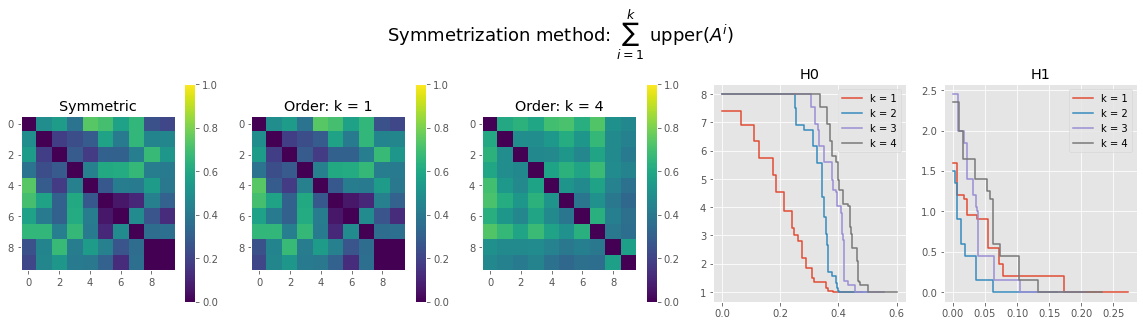

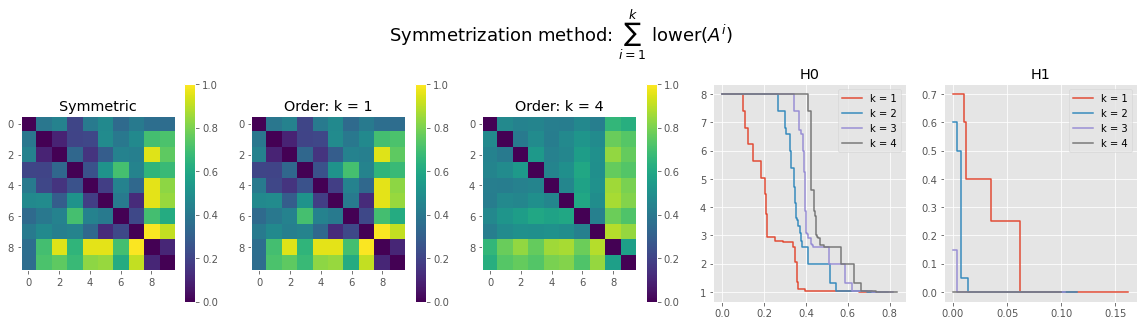

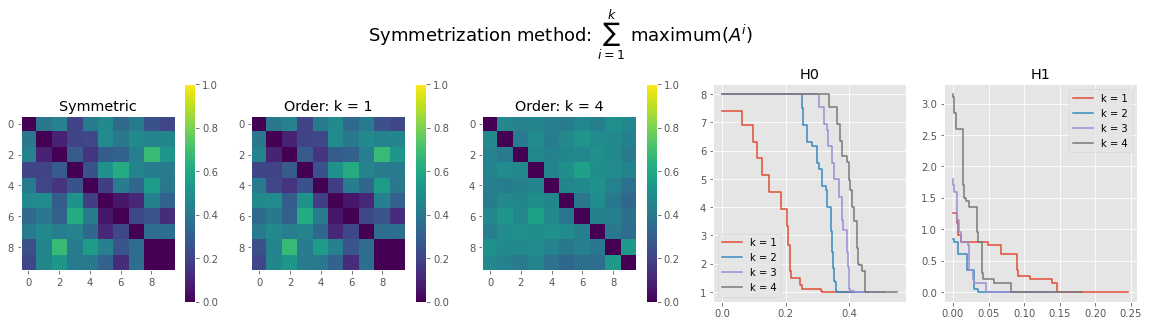

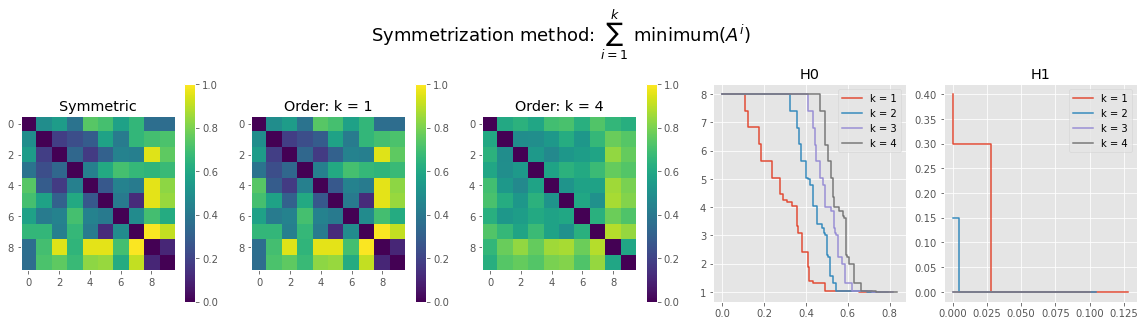

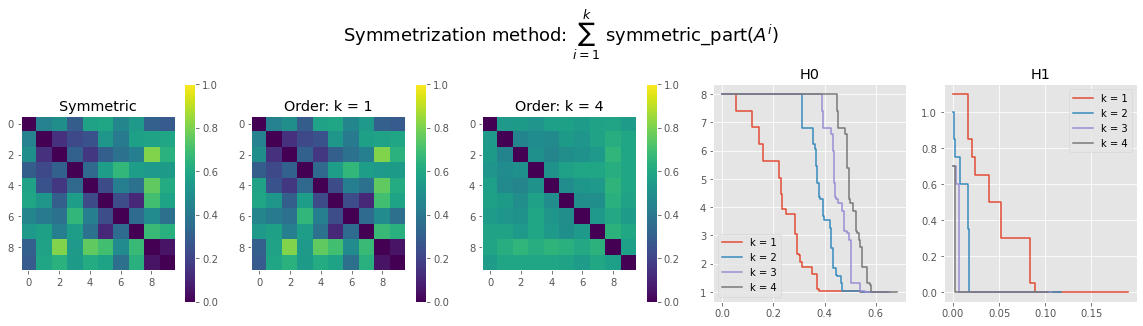

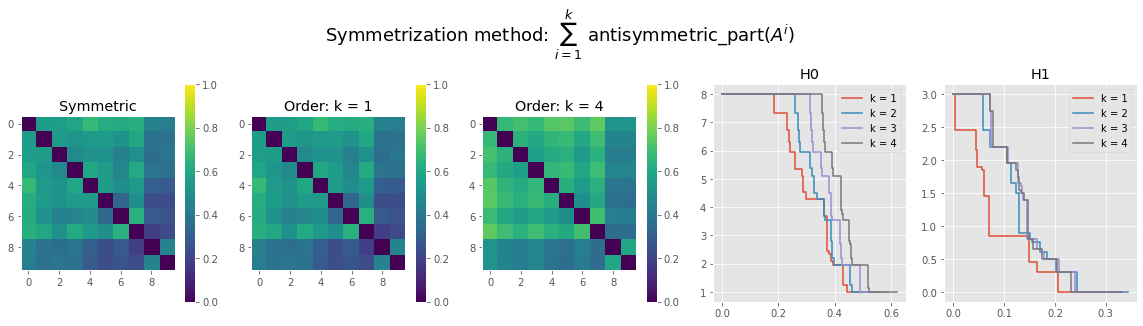

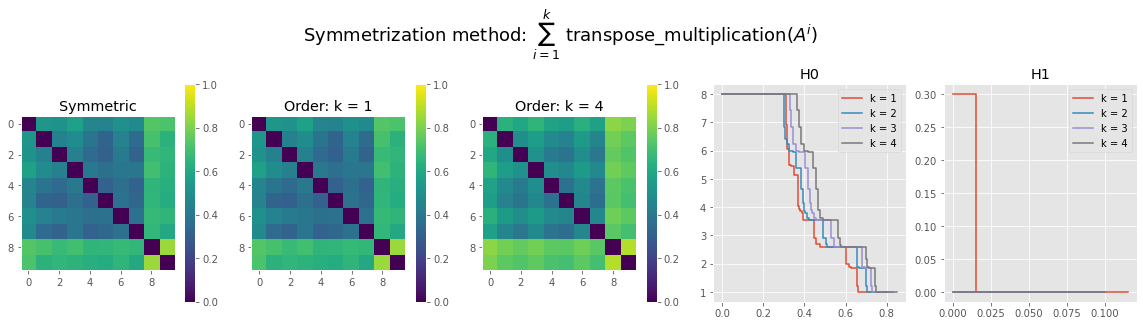

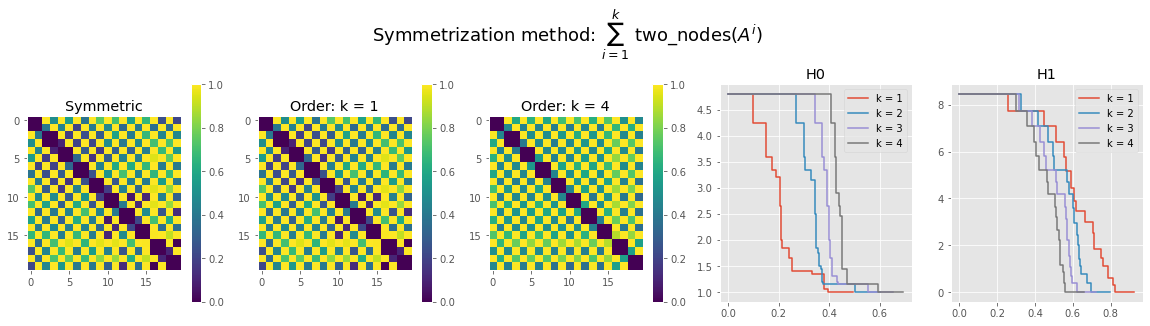

In [307]:
max_order = 4
labels = ["k = "+str(order) for order in range(1, max_order+1)]

for symmetrization in symmetrizations:
    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(20,4))
    plt.rcParams["axes.grid"] = False
    
    d_mat = df.correlation_to_distance(df.symmetrize(symmetrization))
    d = sr.Distance(d_mat)
    ax0.set_title("Symmetric")
    img = ax0.imshow(d.square_form())
    plt.colorbar(img, ax = ax0)
    img.set_clim(0, max_val)
    #ax2.grid(None)
    
    for order in range(1, max_order+1):
        d_mat = df.correlation_to_distance(df.symmetrize_pow(symmetrization, order = order))
        d = sr.Distance(d_mat)
        #h0sr = d.get_h0sr(sample=s, clustering_method="single")
        bc = d.get_bc(maxdim = 1, sample = s)
        h0sr = sr.bc_to_sr(bc, degree="H0")
        h1sr = sr.bc_to_sr(bc, degree="H1")
        
        if order == 1:
            ax1.set_title("Order: k = "+str(order))
            img = ax1.imshow(d.square_form())
            plt.colorbar(img, ax = ax1)
            img.set_clim(0, max_val)
            
        if order == max_order:
            ax2.set_title("Order: k = "+str(order))
            img = ax2.imshow(d.square_form())
            plt.colorbar(img, ax = ax2)
            img.set_clim(0, max_val)

        ax3.set_title("H0")
        ax4.set_title("H1")
        h0sr.plot(ax = ax3)
        h1sr.plot(ax = ax4)
        ax3.grid(True)
        ax4.grid(True)
        
    fig.suptitle("Symmetrization method: $\sum_{i=1}^k$ "+symmetrization+"($A^i$)", fontsize=18, y=1.15)
        
    ax3.legend(labels)
    ax4.legend(labels)

Apply to full data sets

100%|████████████████████████████████████████████████████████████████████| 8/8 [03:39<00:00, 27.40s/it]


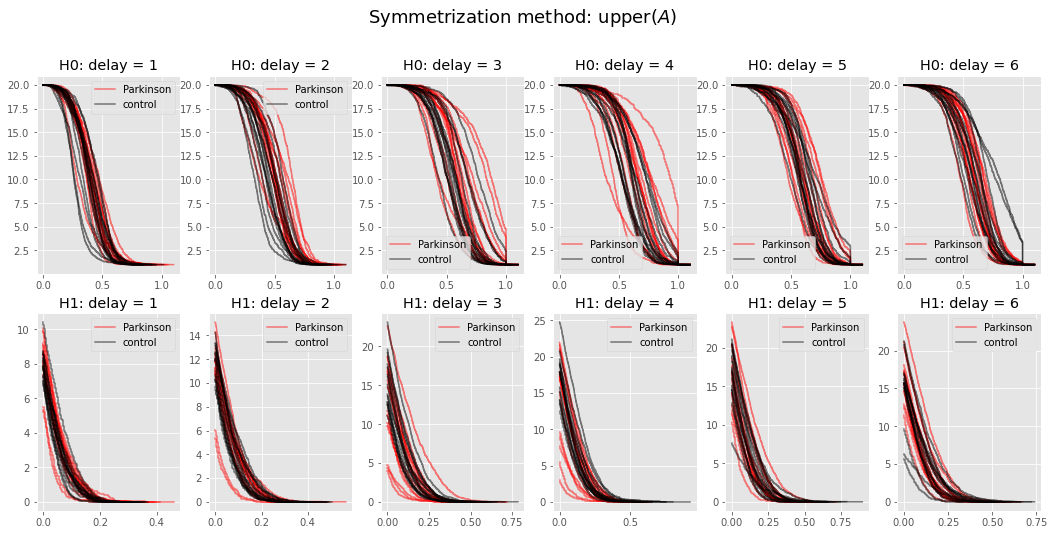

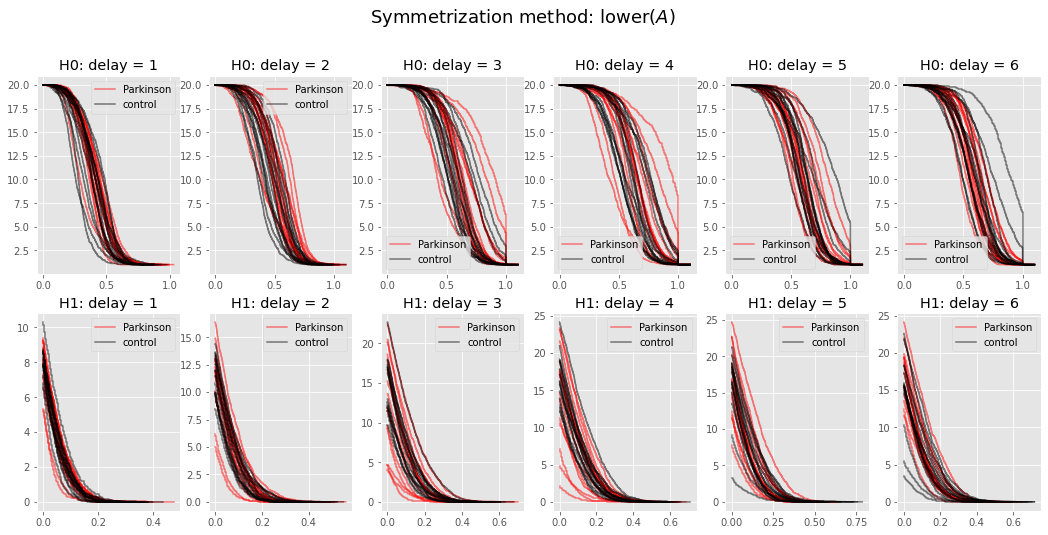

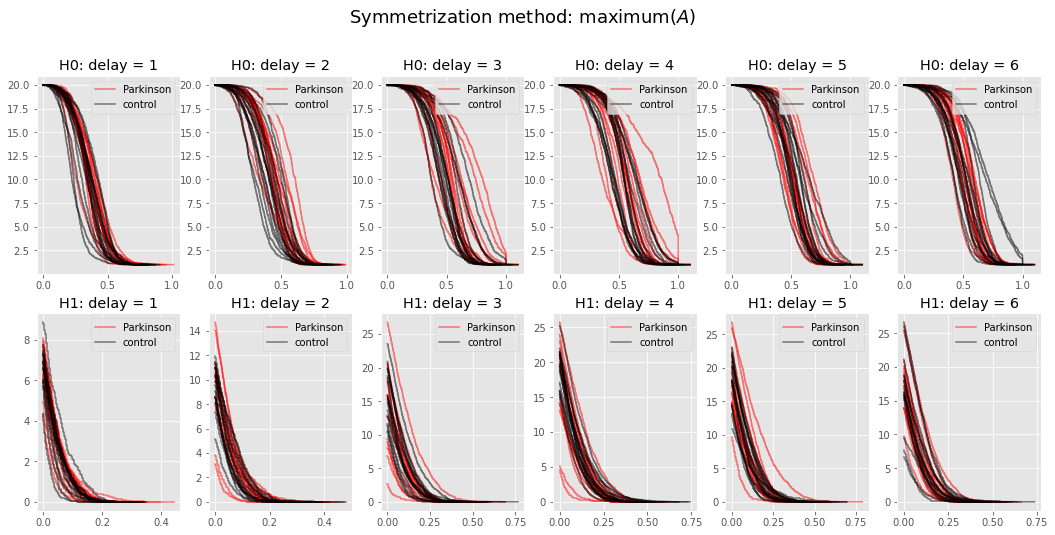

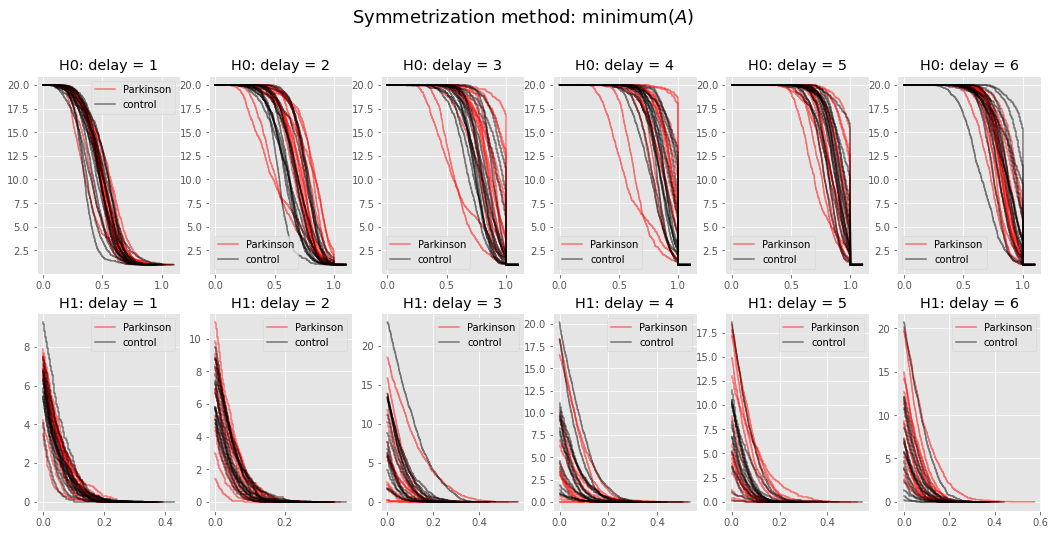

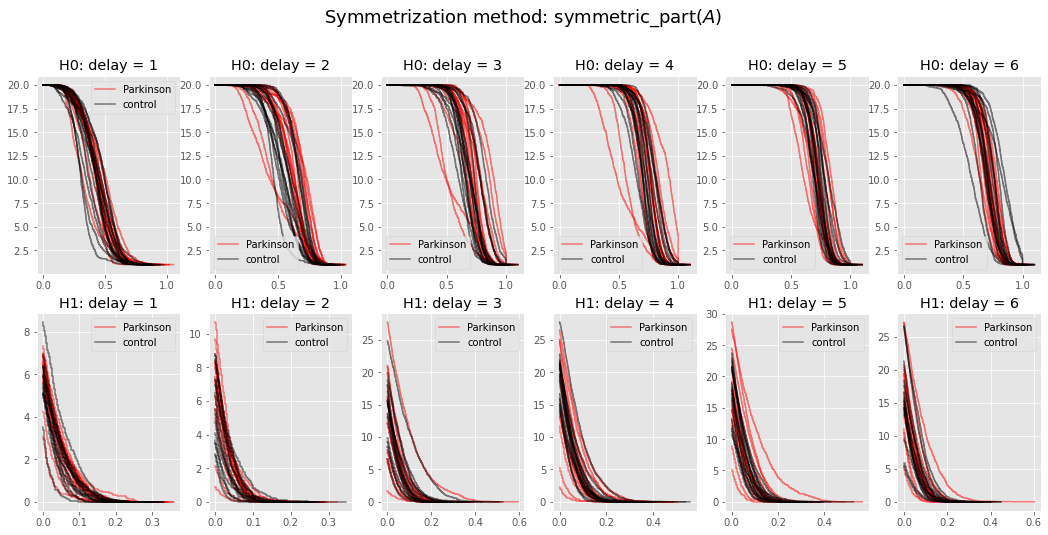

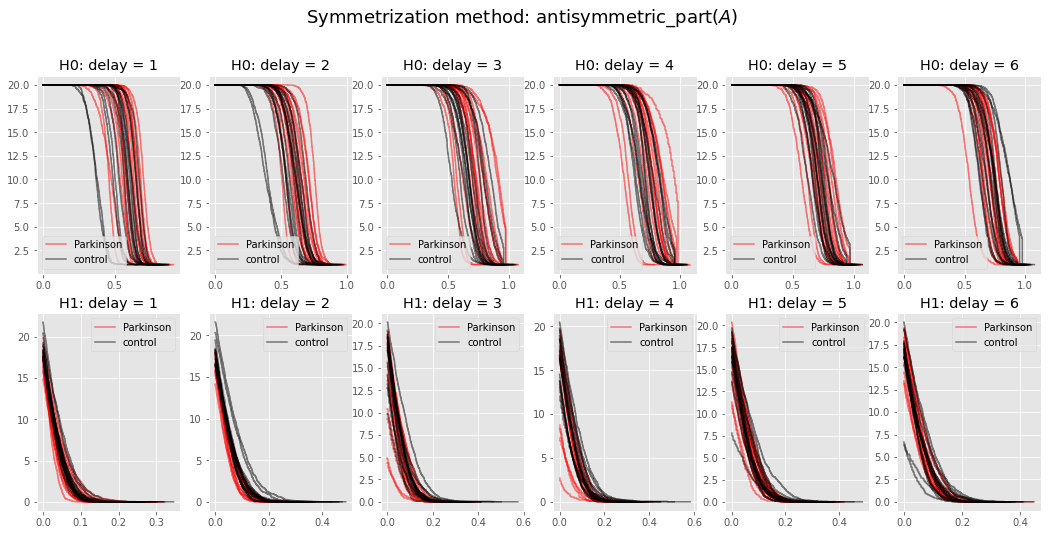

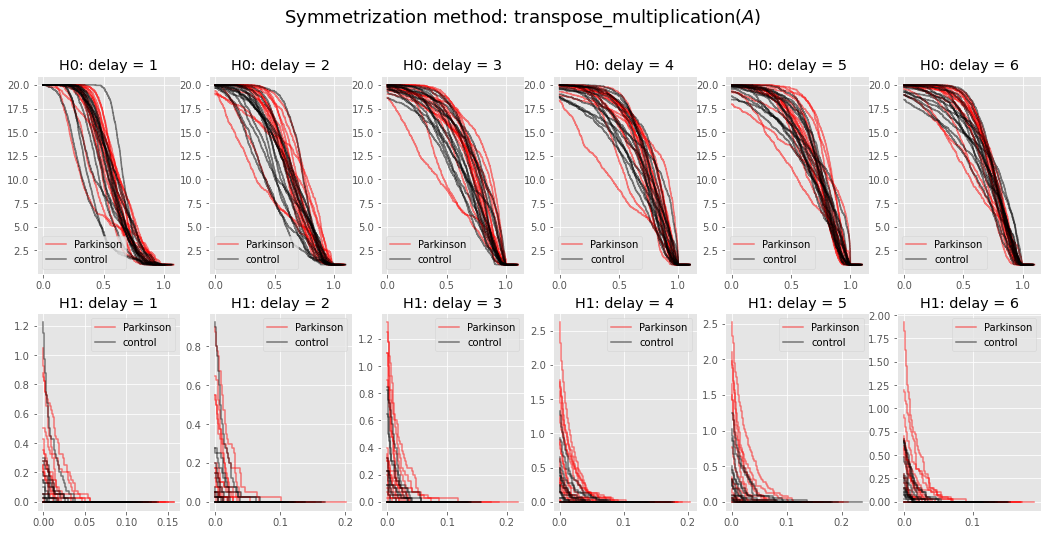

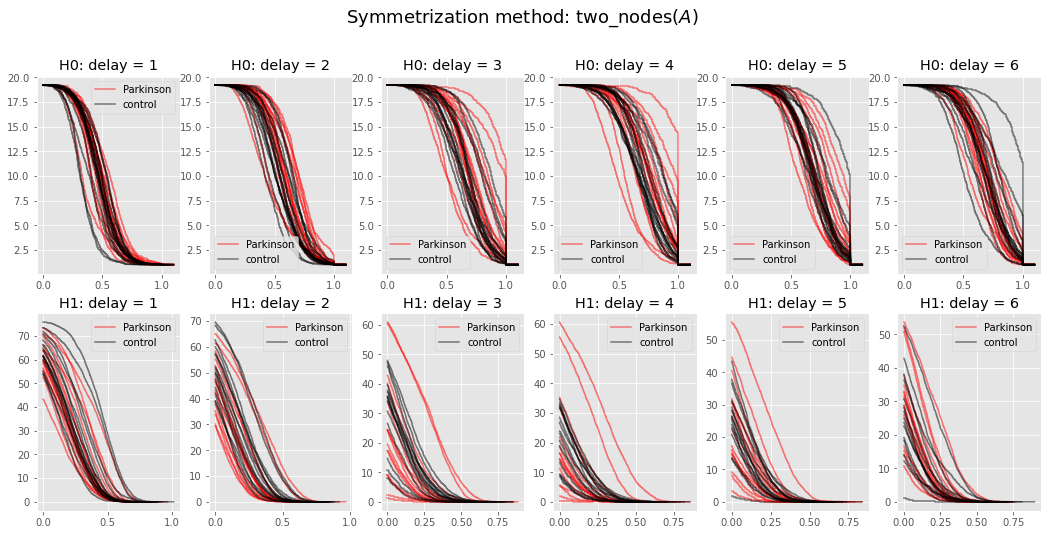

In [310]:
number_instances = 40
sample_size = 20
probabilities = DataFile(delay=1,subject=1).size

s = sr.get_sample(number_instances, sample_size, probabilities)

sranks = dict()
plt.rcParams["axes.grid"] = True

class plot_1Sym_1Delay_allSubjects:
    def __init__(self, symmetrization, delay, range_of_subjects, order = 1):
        self.symmetrization = symmetrization
        self.delay = delay
        self.range_of_subjects = range_of_subjects
        self.order = order
        self.normalize = True
        
    def plot(self, ax):
        #ax.set_title("H0: delay = "+str(self.delay))
        ax[0].set_title("H0: delay = "+str(self.delay))
        ax[1].set_title("H1: delay = "+str(self.delay))
        
        for subject in self.range_of_subjects:
            if subject <= 15:
                color = "k"
            else:
                color = "r"
            df = DataFile(normalize = self.normalize, delay = self.delay, subject = subject)
            d_mat = df.correlation_to_distance(df.symmetrize_pow(symmetrization, order = self.order))
            d = sr.Distance(d_mat)
            #h0sr = d.get_h0sr(sample=s, clustering_method = "single")
            bc = d.get_bc(maxdim=1, sample = s)
            h0sr = sr.bc_to_sr(bc, degree = "H0")
            h1sr = sr.bc_to_sr(bc, degree = "H1")
            
            if subject == 1:
                label = "control"
            elif subject == 16:
                label = "Parkinson"
            else:
                label = "_nolegend_"
            h0sr.plot(ax = ax[0], color = color, label = label, alpha = 0.5)
            h1sr.plot(ax = ax[1], color = color, label = label, alpha = 0.5)

        ax[0].legend()
        ax[1].legend()
        
range_of_subjects = range(30, 0, -1)
range_of_delays = range(1, 7)

for symmetrization in tqdm(symmetrizations):
    fig, axes = plt.subplots(2, len(range_of_delays), figsize=(len(range_of_delays)*3,8))
    fig.suptitle("Symmetrization method: "+symmetrization+"($A$)", fontsize=18, y=1)
    i = 0
    for delay in range_of_delays:
        plot_1Sym_1Delay_allSubjects(symmetrization, delay, range_of_subjects).plot((axes[0,i], axes[1,i]))
        #plot_1Sym_1Delay_allSubjects(symmetrization, delay, range_of_subjects).plot(axes[i])
        i += 1